Install requirements into the `pytorch-gpu` environment

```{bash}
mamba install -c conda-forge -y gcc_linux-64=9.5.0 pycuda pythreejs ipywidgets jupyter_contrib_nbextensions cudatoolkit numba
jupyter labextension install jupyter-threejs 
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

%matplotlib widget


In [2]:
import os
# Add the directory containing 'nvcc' to the PATH
os.environ['PATH'] += os.pathsep + '/opt/conda/envs/pytorch-gpu/bin/'

In [3]:

# Define CUDA kernel for overlap checking
cuda_code = """
__global__ void check_overlap(
    float *positions, float *sizes, int *types,
    float x_new, float y_new, float z_new, float size_new, int type_new,
    int num_shapes, int *result)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx >= num_shapes)
        return;

    float x = positions[3 * idx];
    float y = positions[3 * idx + 1];
    float z = positions[3 * idx + 2];
    float size = sizes[idx];
    int type = types[idx];

    // Approximate all shapes with spheres for overlap checking
    float dx = x_new - x;
    float dy = y_new - y;
    float dz = z_new - z;
    float distance = sqrtf(dx * dx + dy * dy + dz * dz);
    float radius_new = size_new;
    float radius = size;

    if (distance < (radius_new + radius))
        *result = 1;
}
"""

mod = SourceModule(cuda_code)
check_overlap_cuda = mod.get_function("check_overlap")

In [4]:

# Parameters
A_volume = 10000.0  # Total volume to be filled
A0 = 100.0           # Initial volume of the shape
p = 1.2            # Exponent in the decreasing function
n_shapes = 2000000     # Number of shapes to attempt to place
max_particle_size = 50.0
min_particle_size = 0.1

# Shape types: 1 - Sphere, 2 - Cube, 3 - Tetrahedron
shape_types_list = [1,3]

In [5]:

# Generate volumes for each shape
volumes = [A0]
i = 1
while len(volumes) < n_shapes:
    volume = A0 / ((i ** p))
    size = (3 * volume / (4 * np.pi)) ** (1 / 3)  # Radius for spheres
    if size > max_particle_size:
        i += 1
        continue
    volumes.append(volume)
    i += 1

# Shuffle volumes to distribute sizes among shapes
np.random.shuffle(volumes)

# Assign volumes and sizes to shapes
positions = []
sizes = []
types = []

# Define the space dimensions (cube)
L = A_volume ** (1 / 3)

# Initialize arrays for CUDA
positions_array = np.array([], dtype=np.float32)
sizes_array = np.array([], dtype=np.float32)
types_array = np.array([], dtype=np.int32)

# Place the shapes
for idx, volume in enumerate(volumes):
    shape_type = np.random.choice(shape_types_list)
    if shape_type == 1:
        # Sphere
        size = (3 * volume / (4 * np.pi)) ** (1 / 3)
    elif shape_type == 2:
        # Cube
        size = volume ** (1 / 3)
    elif shape_type == 3:
        # Tetrahedron
        size = (volume * (12 / np.sqrt(2))) ** (1 / 3)
    else:
        continue

    current_size = size
    placed = False
    while current_size >= min_particle_size and not placed:
        max_attempts = 1000
        for attempt in range(max_attempts):
            # Generate random position within the space
            x = np.random.uniform(current_size, L - current_size)
            y = np.random.uniform(current_size, L - current_size)
            z = np.random.uniform(current_size, L - current_size)

            # Check for overlap using CUDA
            num_existing = len(sizes_array)
            if num_existing == 0:
                overlap = False
            else:
                overlap_result = np.zeros(1, dtype=np.int32)
                block_size = 256
                grid_size = (num_existing + block_size - 1) // block_size

                check_overlap_cuda(
                    drv.In(positions_array),
                    drv.In(sizes_array),
                    drv.In(types_array),
                    np.float32(x), np.float32(y), np.float32(z),
                    np.float32(current_size),
                    np.int32(shape_type),
                    np.int32(num_existing),
                    drv.Out(overlap_result),
                    block=(block_size, 1, 1),
                    grid=(grid_size, 1)
                )

                overlap = overlap_result[0] == 1

            if not overlap:
                # Place the shape
                positions.append([x, y, z])
                sizes.append(current_size)
                types.append(shape_type)

                # Update CUDA arrays
                positions_array = np.array(positions, dtype=np.float32).flatten()
                sizes_array = np.array(sizes, dtype=np.float32)
                types_array = np.array(types, dtype=np.int32)
                placed = True
                break
        if not placed:
            current_size /= 2.0  # Reduce size and try again
    #if not placed:
        #print(f"Could not place shape {idx+1} even after reducing to minimum size.")
        continue



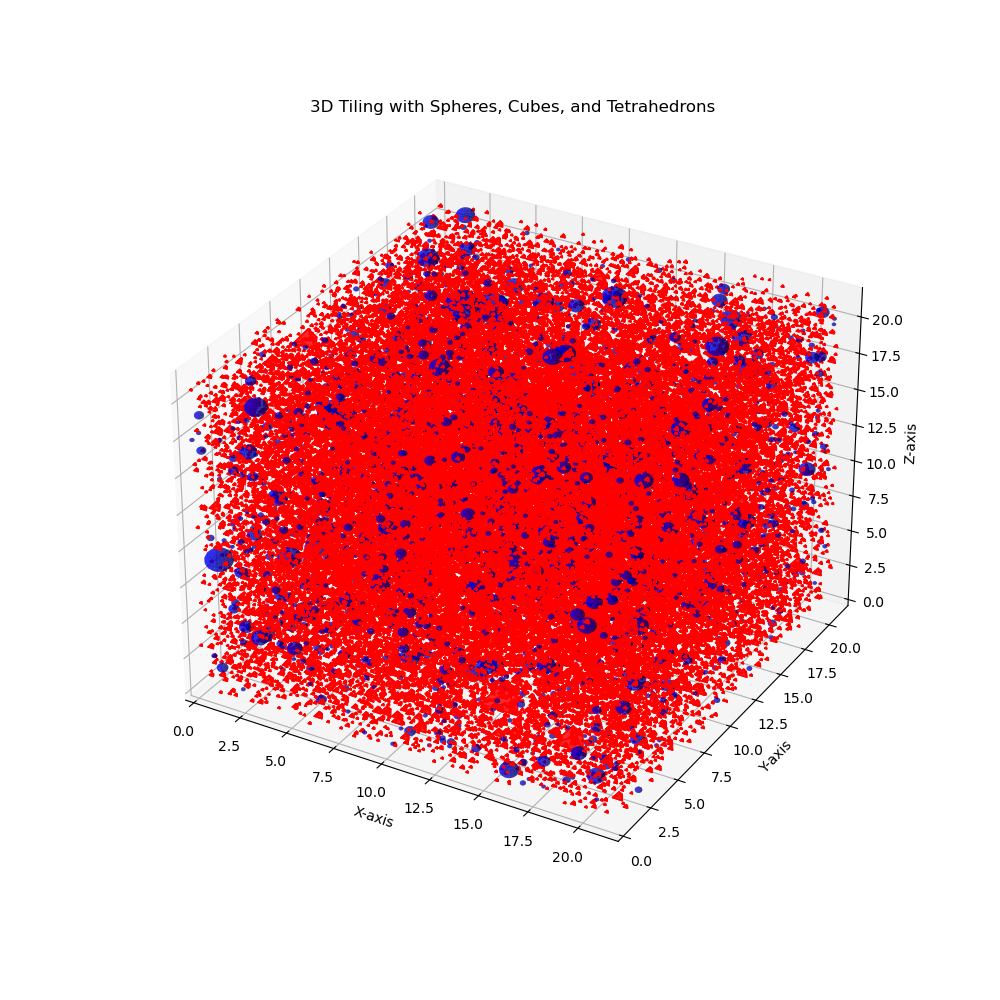

In [6]:

# Visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for (x, y, z), size, shape_type in zip(positions, sizes, types):
    if shape_type == 1:
        # Sphere
        u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
        xs = x + size * np.cos(u) * np.sin(v)
        ys = y + size * np.sin(u) * np.sin(v)
        zs = z + size * np.cos(v)
        ax.plot_surface(xs, ys, zs, color='b', alpha=0.6)
    elif shape_type == 2:
        # Cube
        r = [-size / 2, size / 2]
        # Generate vertices for the cube
        vertices = np.array(list(product(r, r, r))) + np.array([x, y, z])
        # Generate faces of the cube
        faces = [
            [vertices[0], vertices[1], vertices[3], vertices[2]],
            [vertices[4], vertices[5], vertices[7], vertices[6]],
            [vertices[0], vertices[1], vertices[5], vertices[4]],
            [vertices[2], vertices[3], vertices[7], vertices[6]],
            [vertices[1], vertices[3], vertices[7], vertices[5]],
            [vertices[0], vertices[2], vertices[6], vertices[4]],
        ]
        # Add cube to plot
        ax.add_collection3d(
            Poly3DCollection(faces, facecolors='g', linewidths=1, edgecolors='g', alpha=0.6)
        )
    elif shape_type == 3:
        # Tetrahedron
        vertices = np.array([
            [0, 0, 0],
            [size, 0, 0],
            [size / 2, np.sqrt(3) * size / 2, 0],
            [size / 2, np.sqrt(3) * size / 6, np.sqrt(6) * size / 3]
        ]) - size / 2
        vertices += np.array([x, y, z])
        faces = [
            [vertices[0], vertices[1], vertices[2]],
            [vertices[0], vertices[1], vertices[3]],
            [vertices[0], vertices[2], vertices[3]],
            [vertices[1], vertices[2], vertices[3]],
        ]
        poly3d = [[tuple(vertex) for vertex in face] for face in faces]
        ax.add_collection3d(
            Poly3DCollection(poly3d, facecolors='r', linewidths=1, edgecolors='r', alpha=0.6)
        )

# Set plot parameters
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Tiling with Spheres, Cubes, and Tetrahedrons')
plt.show()